In [1]:
import pandas as pd
stk_data = pd.read_csv('GOOG.csv', index_col='Date')
stk_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-20,542.117981,548.528992,541.968567,548.255005,548.255005,6547651
2013-12-23,551.851501,555.816650,550.496582,555.467957,555.467957,3456106
2013-12-24,555.403198,555.537720,551.981018,553.844055,553.844055,1473904
2013-12-26,554.924988,557.410706,552.274963,556.643555,556.643555,2685629
2013-12-27,557.908813,558.048279,554.392029,557.111816,557.111816,3151167


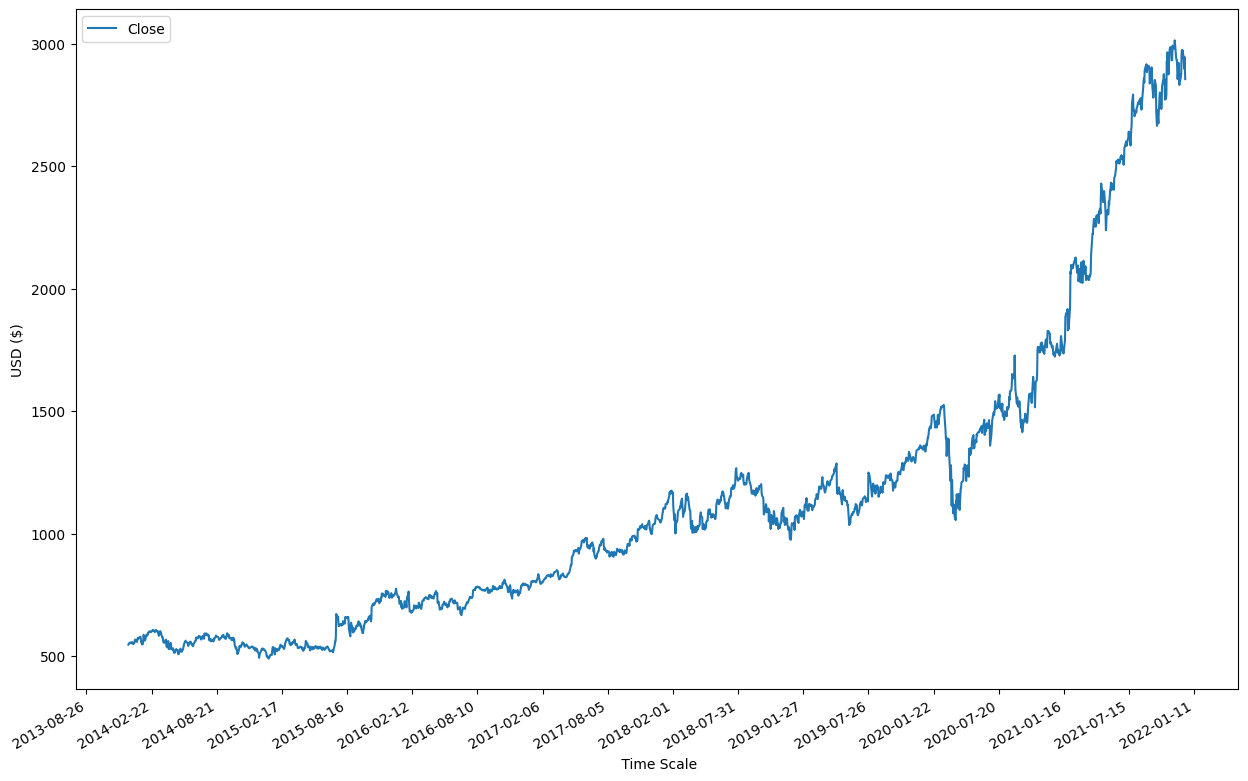

In [2]:
import matplotlib.dates as mdp
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdp.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdp.DayLocator(interval=180))
x_dates= [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in stk_data.index.values]

plt.plot(x_dates, stk_data['Close'], label='Close')
plt.xlabel(' Time Scale')
plt.ylabel('USD ($)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn

In [4]:
#Data Preprocessing
#Target and Features

data_close=stk_data.filter(['Close'])
sub_data=stk_data.iloc[:,0:4]
#feature Scaling
s_data=data_close.values
date_index=stk_data.index
sca=MinMaxScaler(feature_range=(0,1))
normal_data=sca.fit_transform(s_data)



In [5]:
#splitting Train and Test Data

def data_split(data, step_size):
    x,y,z=[],[],[]
    for i in range(step_size,len(data)):
        x.append(data[i-step_size:i,-1])
        y.append(data[i-1,-1])
    return np.array(x), np.array(y)

window_size=30  #The number of days to 
train_rate=0.8


x1, y1=data_split(normal_data, step_size=window_size)

split_index=int(np.ceil(len(x1)*(train_rate)))
x_train,x_test=x1[:split_index],x1[split_index:]
y_train,y_test=y1[:split_index],y1[split_index:]


print(x1.shape,x_train.shape,x_test.shape,y_train.shape, y_test.shape)    


#for i in range(window_size,len(test_data)):
#    xx_test.append(test_data[i-window_size:i,0])
#x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

y_train=np.reshape(y_train,(y_train.shape[0],1))
y_test=np.reshape(y_test,(y_test.shape[0],1))

print(x_train.shape)
print(y_test.shape)

(1983, 30) (1587, 30) (396, 30) (1587,) (396,)
(1587, 30, 1)
(396, 1)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=3, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions


In [59]:
# Initialize the LSTM model
lstm_model = LSTMModel(1 , 50, 1, 3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

# Convert data to tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)

# Training loop
epochs = 100
for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    y_pred_train_lstm1 = lstm_model(x_train_tensor)
    loss = criterion(y_pred_train_lstm1, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.022486114874482155
Epoch 11, Loss: 0.01262205932289362
Epoch 21, Loss: 0.01141649205237627
Epoch 31, Loss: 0.010571119375526905
Epoch 41, Loss: 0.008207186125218868
Epoch 51, Loss: 0.002786333207041025
Epoch 61, Loss: 0.0013069026172161102
Epoch 71, Loss: 0.0007373020052909851
Epoch 81, Loss: 0.0005851027672179043
Epoch 91, Loss: 0.0005169952637515962


In [60]:
lstm_model.eval()
with torch.no_grad():
    x_test_tensor = torch.Tensor(x_test)
    y_pred_test_lstm1 = lstm_model(x_test_tensor)
    test_loss = criterion(y_pred_test_lstm1, torch.Tensor(y_test))
    print(f'Test Loss (MSE): {test_loss.item()}')

# Convert predictions and actual values back to numpy arrays for evaluation
y_pred_test_lstm1 = y_pred_test_lstm1.numpy()
y_test = np.array(y_test)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_test_lstm1) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Test Loss (MSE): 0.060929540544748306
Mean Absolute Percentage Error (MAPE): 25.43951350213714%


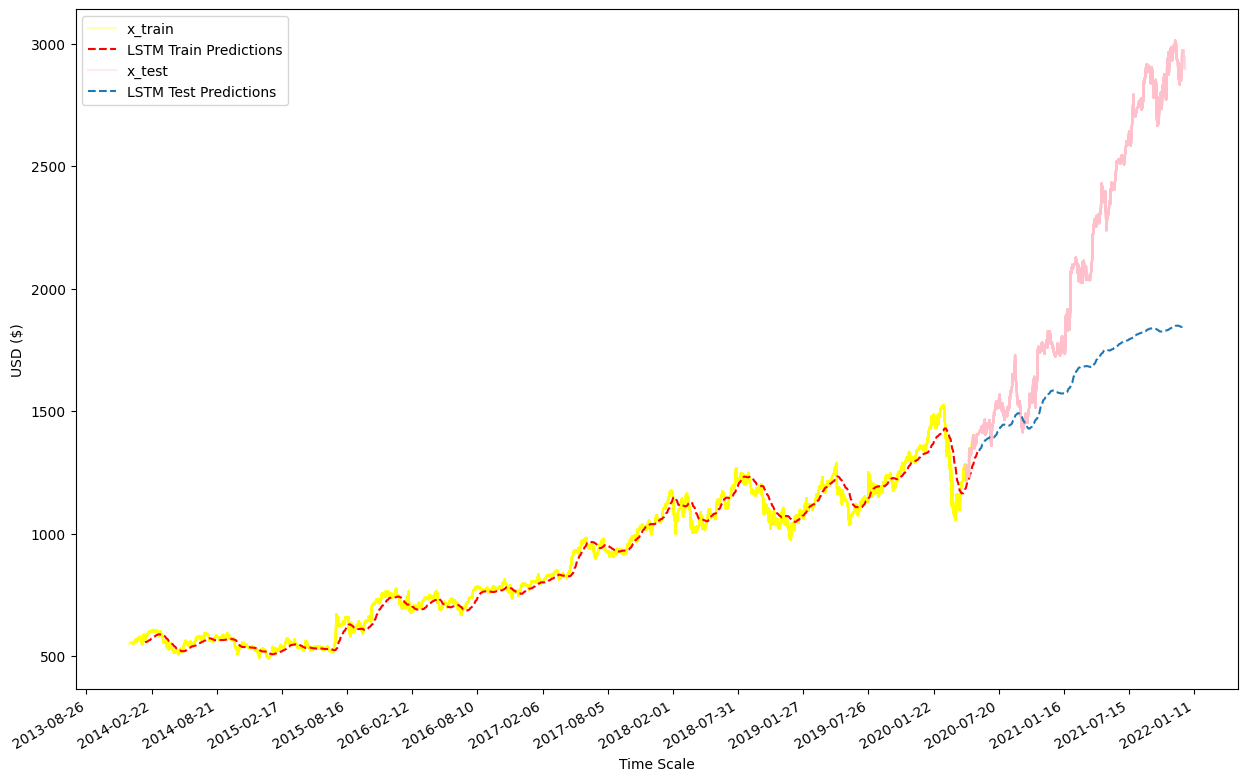

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# فرض می‌کنیم که داده‌ها بین 0 و 1 نرمال‌سازی شده‌اند
# استفاده از شیء MinMaxScaler برای بازگرداندن پیش‌بینی‌ها به مقیاس اصلی
sca = MinMaxScaler(feature_range=(0,1))
sca.fit(data_close.values)

# تبدیل تاریخ‌ها به فرمت مناسب برای نمایش
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stk_data.index.values]

# بازگرداندن داده‌های x_train و x_test به مقیاس اصلی
x_train_rescaled = sca.inverse_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_rescaled = sca.inverse_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

# محاسبه پیش‌بینی‌ها برای داده‌های آموزش
lstm_model.eval()
with torch.no_grad():
    y_pred_train_lstm1 = lstm_model(torch.Tensor(x_train)).numpy()
    y_pred_train_lstm1_rescaled = sca.inverse_transform(y_pred_train_lstm1)

# بازگرداندن پیش‌بینی‌های داده‌های تست به مقیاس اصلی
y_pred_test_lstm1_rescaled = sca.inverse_transform(y_pred_test_lstm1) # type: ignore

# تعیین تاریخ‌های داده‌های آموزش و تست
train_dates = x_dates[window_size-1:len(y_pred_train_lstm1_rescaled)+window_size-1]
test_dates = x_dates[len(x_dates)-len(y_pred_test_lstm1_rescaled):]

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))

# # نمودار قیمت بسته‌شده
# plt.plot(x_dates, stk_data['Close'], label='Close')
for i in range(len(x_train_rescaled)):
    plt.plot(x_dates[i:i+window_size], x_train_rescaled[i].flatten(), color="yellow", alpha=0.3, label='x_train' if i == 0 else "")

# نمودار پیش‌بینی‌های مدل GRU برای داده‌های آموزش
plt.plot(train_dates, y_pred_train_lstm1_rescaled, color='red', label='LSTM Train Predictions', linestyle='--')

# نمودار داده‌های x_test
for i in range(len(x_test_rescaled)):
    plt.plot(x_dates[len(x_dates)-len(x_test_rescaled)+i-window_size+1:len(x_dates)-len(x_test_rescaled)+i+1], 
             x_test_rescaled[i].flatten(), color='pink', alpha=0.3, label='x_test' if i == 0 else "")
    
# نمودار پیش‌بینی‌های مدل GRU برای داده‌های تست
plt.plot(test_dates, y_pred_test_lstm1_rescaled, label='LSTM Test Predictions', linestyle='--')

# نمودار داده‌های x_train


plt.xlabel('Time Scale')
plt.ylabel('USD ($)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [62]:
# Initialize the LSTM model
lstm_model2 = LSTMModel(1 , 50, 1, 2)
optimizer = torch.optim.Adam(lstm_model2.parameters(), lr=0.001)

# Convert data to tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)

# Training loop
epochs = 100
for epoch in range(epochs):
    lstm_model2.train()
    optimizer.zero_grad()
    y_pred_train_lstm12 = lstm_model2(x_train_tensor)
    loss = criterion(y_pred_train_lstm12, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.012983018532395363
Epoch 11, Loss: 0.010533173568546772
Epoch 21, Loss: 0.008794614113867283
Epoch 31, Loss: 0.0026916186325252056
Epoch 41, Loss: 0.0005962776485830545
Epoch 51, Loss: 0.0006223222007974982
Epoch 61, Loss: 0.00046428083442151546
Epoch 71, Loss: 0.00037754999357275665
Epoch 81, Loss: 0.0003426958865020424
Epoch 91, Loss: 0.0003332345513626933


In [67]:
lstm_model2.eval()
with torch.no_grad():
    x_test_tensor = torch.Tensor(x_test)
    y_pred_test_lstm2 = lstm_model2(x_test_tensor)
    test_loss = criterion(y_pred_test_lstm2, torch.Tensor(y_test))
    print(f'Test Loss (MSE): {test_loss.item()}')

# Convert predictions and actual values back to numpy arrays for evaluation
y_pred_test_lstm2 = y_pred_test_lstm2.numpy()
y_test = np.array(y_test)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_test_lstm2) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Test Loss (MSE): 0.0072532291524112225
Mean Absolute Percentage Error (MAPE): 8.613207488208356%


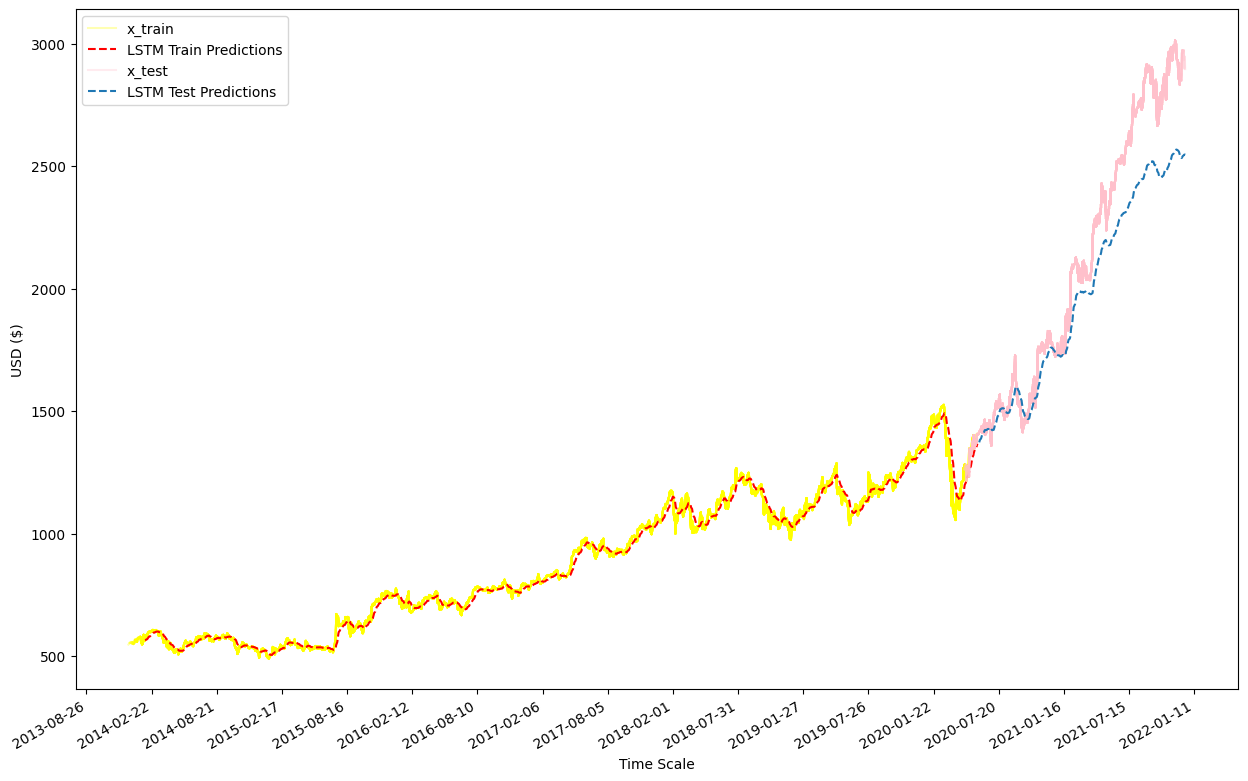

In [68]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# فرض می‌کنیم که داده‌ها بین 0 و 1 نرمال‌سازی شده‌اند
# استفاده از شیء MinMaxScaler برای بازگرداندن پیش‌بینی‌ها به مقیاس اصلی
sca = MinMaxScaler(feature_range=(0,1))
sca.fit(data_close.values)

# تبدیل تاریخ‌ها به فرمت مناسب برای نمایش
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stk_data.index.values]

# بازگرداندن داده‌های x_train و x_test به مقیاس اصلی
x_train_rescaled = sca.inverse_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_rescaled = sca.inverse_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

# محاسبه پیش‌بینی‌ها برای داده‌های آموزش
lstm_model2.eval()
with torch.no_grad():
    y_pred_train_lstm2 = lstm_model2(torch.Tensor(x_train)).numpy()
    y_pred_train_lstm2_rescaled = sca.inverse_transform(y_pred_train_lstm2)

# بازگرداندن پیش‌بینی‌های داده‌های تست به مقیاس اصلی
y_pred_test_lstm2_rescaled = sca.inverse_transform(y_pred_test_lstm2) # type: ignore

# تعیین تاریخ‌های داده‌های آموزش و تست
train_dates = x_dates[window_size-1:len(y_pred_train_lstm2_rescaled)+window_size-1]
test_dates = x_dates[len(x_dates)-len(y_pred_test_lstm2_rescaled):]

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))

# # نمودار قیمت بسته‌شده
# plt.plot(x_dates, stk_data['Close'], label='Close')
for i in range(len(x_train_rescaled)):
    plt.plot(x_dates[i:i+window_size], x_train_rescaled[i].flatten(), color="yellow", alpha=0.3, label='x_train' if i == 0 else "")

# نمودار پیش‌بینی‌های مدل GRU برای داده‌های آموزش
plt.plot(train_dates, y_pred_train_lstm2_rescaled, color='red', label='LSTM Train Predictions', linestyle='--')

# نمودار داده‌های x_test
for i in range(len(x_test_rescaled)):
    plt.plot(x_dates[len(x_dates)-len(x_test_rescaled)+i-window_size+1:len(x_dates)-len(x_test_rescaled)+i+1], 
             x_test_rescaled[i].flatten(), color='pink', alpha=0.3, label='x_test' if i == 0 else "")
    
# نمودار پیش‌بینی‌های مدل GRU برای داده‌های تست
plt.plot(test_dates, y_pred_test_lstm2_rescaled, label='LSTM Test Predictions', linestyle='--')

# نمودار داده‌های x_train


plt.xlabel('Time Scale')
plt.ylabel('USD ($)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [9]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=3, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        gru_out, _ = self.gru(x, h0)
        gru_out = self.dropout(gru_out)
        predictions = self.linear(gru_out[:, -1, :])
        return predictions


In [19]:
# Initialize the GRU model
gru_model = GRUModel(1 , 50, 1, 3)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

# Convert data to tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)

# Training loop
epochs = 100
for epoch in range(epochs):
    gru_model.train()
    optimizer.zero_grad()
    y_pred_train1 = gru_model(x_train_tensor)
    loss = criterion(y_pred_train1, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.015028218738734722
Epoch 11, Loss: 0.010685724206268787
Epoch 21, Loss: 0.006420791149139404
Epoch 31, Loss: 0.0007063061930239201
Epoch 41, Loss: 0.0005910694017075002
Epoch 51, Loss: 0.0006081506726332009
Epoch 61, Loss: 0.00048375219921581447
Epoch 71, Loss: 0.0004004799702670425
Epoch 81, Loss: 0.00035873116576112807
Epoch 91, Loss: 0.0003366006421856582


In [25]:
gru_model.eval()
with torch.no_grad():
    x_test_tensor = torch.Tensor(x_test)
    y_pred_test1 = gru_model(x_test_tensor)
    test_loss = criterion(y_pred_test1, torch.Tensor(y_test))
    print(f'Test Loss (MSE): {test_loss.item()}')

# Calculate Mean Absolute Percentage Error (MAPE)
y_pred_test1 = y_pred_test1.numpy()
mape = np.mean(np.abs((y_test - y_pred_test1) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Test Loss (MSE): 0.0024266745895147324
Mean Absolute Percentage Error (MAPE): 5.2437822813572295%


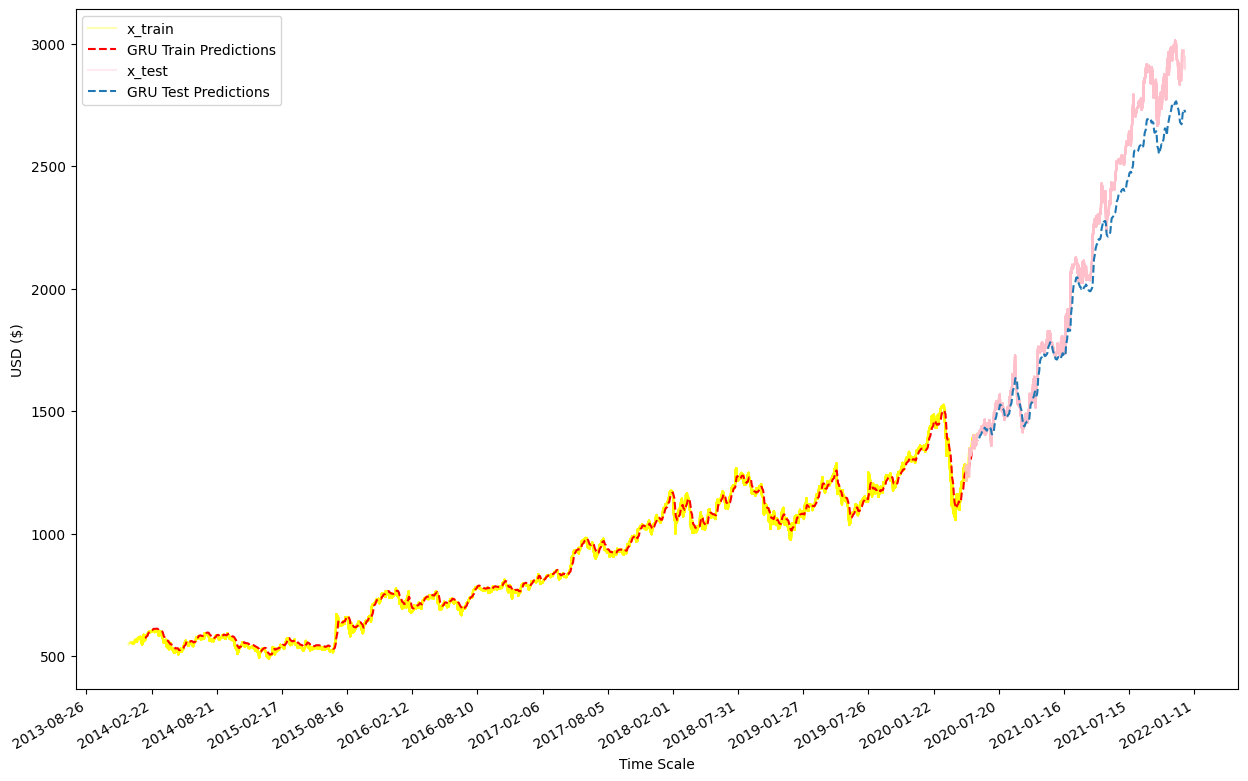

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# فرض می‌کنیم که داده‌ها بین 0 و 1 نرمال‌سازی شده‌اند
# استفاده از شیء MinMaxScaler برای بازگرداندن پیش‌بینی‌ها به مقیاس اصلی
sca = MinMaxScaler(feature_range=(0,1))
sca.fit(data_close.values)

# تبدیل تاریخ‌ها به فرمت مناسب برای نمایش
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stk_data.index.values]

# بازگرداندن داده‌های x_train و x_test به مقیاس اصلی
x_train_rescaled = sca.inverse_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_rescaled = sca.inverse_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

# محاسبه پیش‌بینی‌ها برای داده‌های آموزش
gru_model.eval()
with torch.no_grad():
    y_pred_train1 = gru_model(torch.Tensor(x_train)).numpy()
    y_pred_train1_rescaled = sca.inverse_transform(y_pred_train1)

# بازگرداندن پیش‌بینی‌های داده‌های تست به مقیاس اصلی
y_pred_test1_rescaled = sca.inverse_transform(y_pred_test1) # type: ignore

# تعیین تاریخ‌های داده‌های آموزش و تست
train_dates = x_dates[window_size-1:len(y_pred_train1_rescaled)+window_size-1]
test_dates = x_dates[len(x_dates)-len(y_pred_test1_rescaled):]

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))

# # نمودار قیمت بسته‌شده
# plt.plot(x_dates, stk_data['Close'], label='Close')
for i in range(len(x_train_rescaled)):
    plt.plot(x_dates[i:i+window_size], x_train_rescaled[i].flatten(), color="yellow", alpha=0.3, label='x_train' if i == 0 else "")

# نمودار پیش‌بینی‌های مدل GRU برای داده‌های آموزش
plt.plot(train_dates, y_pred_train1_rescaled, color='red', label='GRU Train Predictions', linestyle='--')

# نمودار داده‌های x_test
for i in range(len(x_test_rescaled)):
    plt.plot(x_dates[len(x_dates)-len(x_test_rescaled)+i-window_size+1:len(x_dates)-len(x_test_rescaled)+i+1], 
             x_test_rescaled[i].flatten(), color='pink', alpha=0.3, label='x_test' if i == 0 else "")
    
# نمودار پیش‌بینی‌های مدل GRU برای داده‌های تست
plt.plot(test_dates, y_pred_test1_rescaled, label='GRU Test Predictions', linestyle='--')

# نمودار داده‌های x_train


plt.xlabel('Time Scale')
plt.ylabel('USD ($)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [12]:
# Initialize the GRU model
gru_model2 = GRUModel(1 , 50, 1, 5)
optimizer = torch.optim.Adam(gru_model2.parameters(), lr=0.001)

# Convert data to tensors
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)

# Training loop
epochs = 100
for epoch in range(epochs):
    gru_model2.train()
    optimizer.zero_grad()
    y_pred_train2 = gru_model2(x_train_tensor)
    loss = criterion(y_pred_train2, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 0.06995011866092682
Epoch 11, Loss: 0.012883752584457397
Epoch 21, Loss: 0.01235398929566145
Epoch 31, Loss: 0.011404587887227535
Epoch 41, Loss: 0.009620225057005882
Epoch 51, Loss: 0.0021642965730279684
Epoch 61, Loss: 0.0010897641768679023
Epoch 71, Loss: 0.0010808369843289256
Epoch 81, Loss: 0.0008766651153564453
Epoch 91, Loss: 0.0008164222235791385


In [16]:
gru_model2.eval()
with torch.no_grad():
    x_test_tensor = torch.Tensor(x_test)
    y_pred_test2 = gru_model2(x_test_tensor)
    test_loss = criterion(y_pred_test2, torch.Tensor(y_test))
    print(f'Test Loss (MSE): {test_loss.item()}')

# Calculate Mean Absolute Percentage Error (MAPE)
y_pred_test2 = y_pred_test2.numpy()
mape = np.mean(np.abs((y_test - y_pred_test2) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

Test Loss (MSE): 0.013999076560139656
Mean Absolute Percentage Error (MAPE): 11.394040656154111%


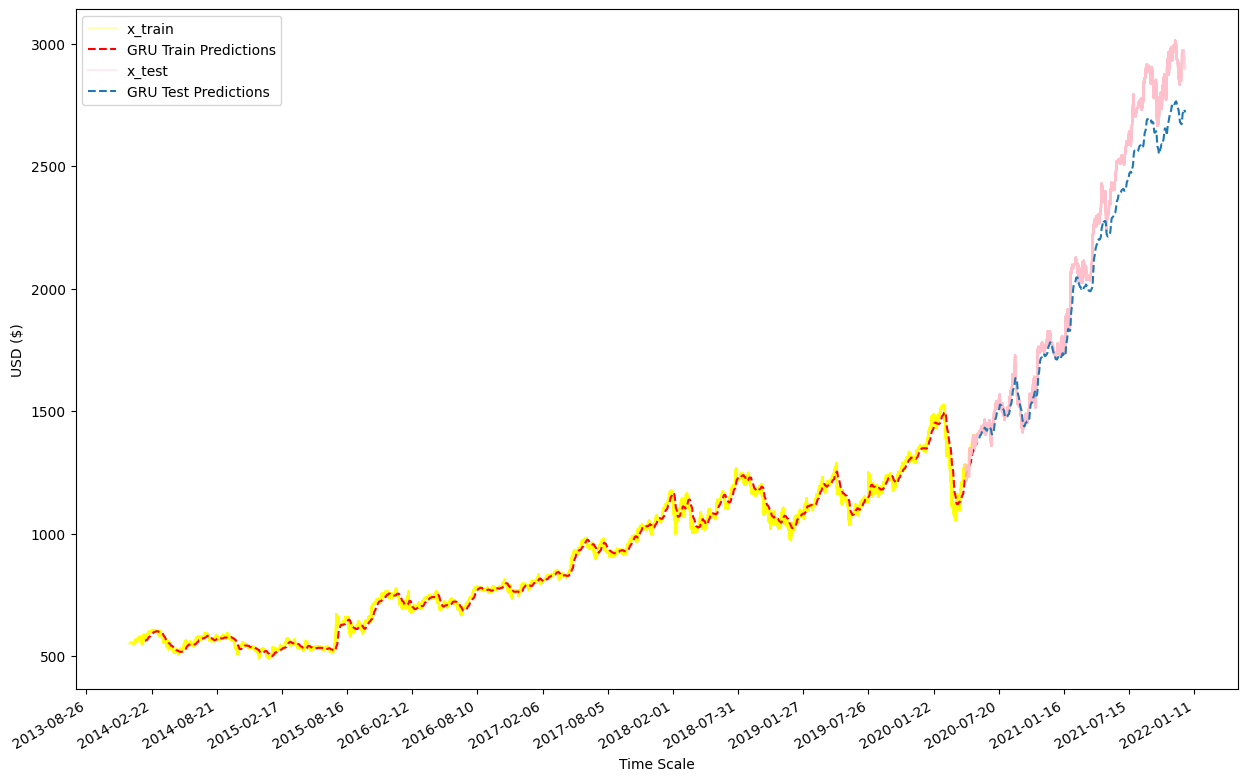

In [70]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# فرض می‌کنیم که داده‌ها بین 0 و 1 نرمال‌سازی شده‌اند
# استفاده از شیء MinMaxScaler برای بازگرداندن پیش‌بینی‌ها به مقیاس اصلی
sca = MinMaxScaler(feature_range=(0,1))
sca.fit(data_close.values)

# تبدیل تاریخ‌ها به فرمت مناسب برای نمایش
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stk_data.index.values]

# بازگرداندن داده‌های x_train و x_test به مقیاس اصلی
x_train_rescaled = sca.inverse_transform(x_train.reshape(-1, 1)).reshape(x_train.shape)
x_test_rescaled = sca.inverse_transform(x_test.reshape(-1, 1)).reshape(x_test.shape)

# محاسبه پیش‌بینی‌ها برای داده‌های آموزش
gru_model2.eval()
with torch.no_grad():
    y_pred_train2 = gru_model2(torch.Tensor(x_train)).numpy()
    y_pred_train2_rescaled = sca.inverse_transform(y_pred_train2)

# بازگرداندن پیش‌بینی‌های داده‌های تست به مقیاس اصلی
y_pred_test2_rescaled = sca.inverse_transform(y_pred_test2)

# تعیین تاریخ‌های داده‌های آموزش و تست
train_dates = x_dates[window_size-1:len(y_pred_train2_rescaled)+window_size-1]
test_dates = x_dates[len(x_dates)-len(y_pred_test2_rescaled):]

plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))

# # نمودار قیمت بسته‌شده
# plt.plot(x_dates, stk_data['Close'], label='Close')

# نمودار داده‌های x_train
for i in range(len(x_train_rescaled)):
    plt.plot(x_dates[i:i+window_size], x_train_rescaled[i].flatten(), color='yellow', alpha=0.3, label='x_train' if i == 0 else "")
    
# نمودار پیش‌بینی‌های مدل GRU برای داده‌های آموزش
plt.plot(train_dates, y_pred_train2_rescaled, color='red',label='GRU Train Predictions', linestyle='--')

# نمودار داده‌های x_test
for i in range(len(x_test_rescaled)):
    plt.plot(x_dates[len(x_dates)-len(x_test_rescaled)+i-window_size+1:len(x_dates)-len(x_test_rescaled)+i+1], 
             x_test_rescaled[i].flatten(), color='pink', alpha=0.3, label='x_test' if i == 0 else "")

# نمودار پیش‌بینی‌های مدل GRU برای داده‌های تست
plt.plot(test_dates, y_pred_test2_rescaled, label='GRU Test Predictions', linestyle='--')



plt.xlabel('Time Scale')
plt.ylabel('USD ($)')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
